In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from xgboost import XGBRFClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA 
import joblib


## 1. Data Loading dan Exploratory Data Analysis

In [5]:
df = pd.read_csv('../data/data_balita.csv')

In [6]:
print('Dataset Shape:', df.shape)

Dataset Shape: (120999, 4)


In [7]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB
None


In [8]:
print('First 5 rows:')
display(df.head())

First 5 rows:


,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [9]:
print('Dataset Description:')
display(df.describe())

Dataset Description:


,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [10]:
df.describe(include='O')

,Jenis Kelamin,Status Gizi
count,120999,120999
unique,2,4
top,perempuan,normal
freq,61002,67755


In [11]:
# Check for missing values
print('Missing Values:')
print(df.isnull().sum())

Missing Values:
Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64


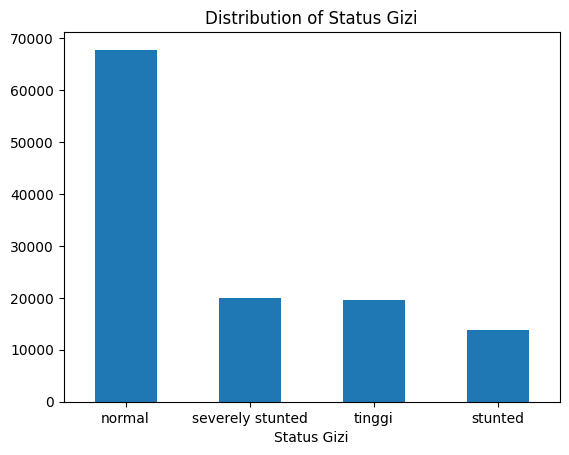

In [13]:
# Value counts for target variable
df['Status Gizi'].value_counts().plot(kind='bar', title='Distribution of Status Gizi', rot=0)
plt.show()

## 2. Data Visualization

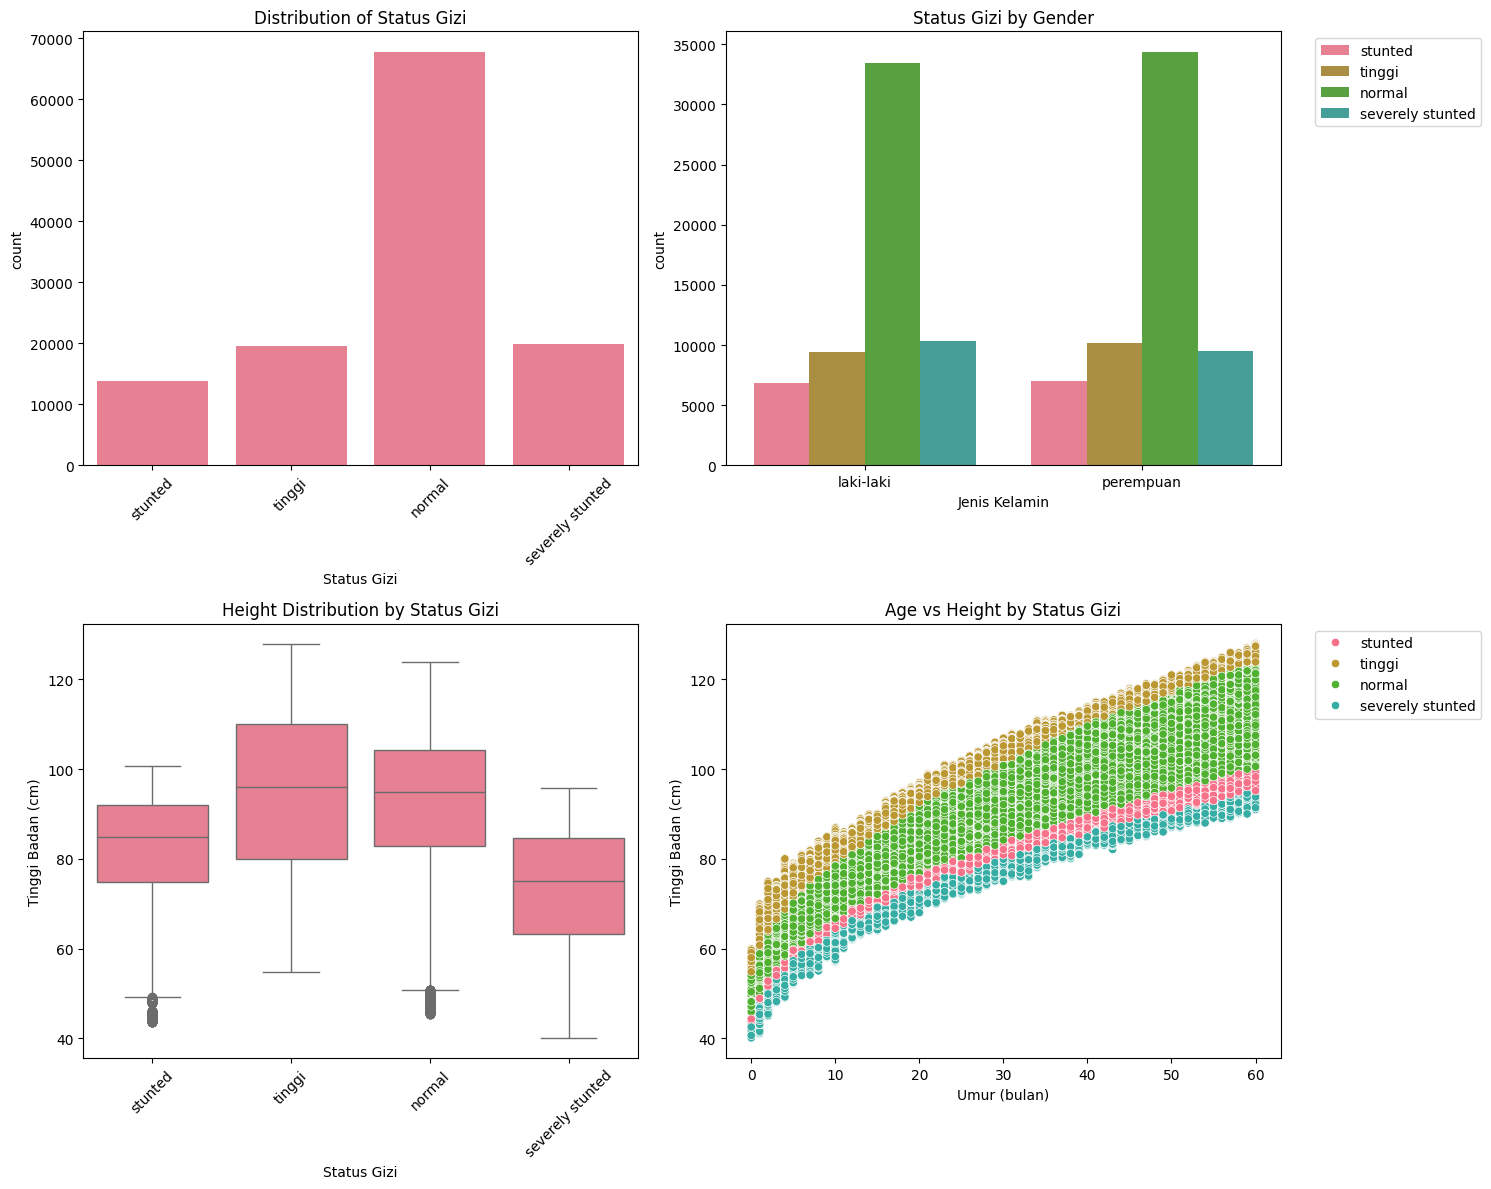

In [14]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette('husl')

# create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of Status Gizi
sns.countplot(data=df, x='Status Gizi', ax=axes[0,0])
axes[0, 0].set_title('Distribution of Status Gizi')
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribution by Gender
sns.countplot(data=df, x='Jenis Kelamin', hue='Status Gizi', ax=axes[0,1])
axes[0,1].set_title('Status Gizi by Gender')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Height distribution by Status Gizi
sns.boxplot(data=df, x='Status Gizi', y='Tinggi Badan (cm)', ax=axes[1,0])
axes[1, 0].set_title('Height Distribution by Status Gizi')
axes[1,0].tick_params(axis='x', rotation=45)

# Age vs Height scatter plot
sns.scatterplot(data=df, x='Umur (bulan)', y='Tinggi Badan (cm)',
                hue='Status Gizi', ax=axes[1,1])
axes[1,1].set_title('Age vs Height by Status Gizi')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [16]:
# Create a copy of the dataset for preprocessing
df_processed = df.copy()

# Encode categorical variables
le_gender = LabelEncoder()
le_status = LabelEncoder()

df_processed['Jenis Kelamin_encoded'] = le_gender.fit_transform(df_processed['Jenis Kelamin'])
df_processed['Status Gizi_encoded'] = le_status.fit_transform(df_processed['Status Gizi'])

# Prepare features and target for classification
X = df_processed[['Umur (bulan)', 'Jenis Kelamin_encoded', 'Tinggi Badan (cm)']]
y = df_processed['Status Gizi_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

# Scaler the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Label encoding mapping:')
print('Gender:', dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print('Status Gizi:', dict(zip(le_status.classes_, le_status.transform(le_status.classes_))))

Training set shape: (96799, 3)
Test set shape: (24200, 3)
Label encoding mapping:
Gender: {'laki-laki': np.int64(0), 'perempuan': np.int64(1)}
Status Gizi: {'normal': np.int64(0), 'severely stunted': np.int64(1), 'stunted': np.int64(2), 'tinggi': np.int64(3)}


In [17]:
# Save the preprocessing model
joblib.dump(le_gender, '../models/le_gender.pkl')
joblib.dump(le_status, '../models/le_status.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

## 4. Classification Models

In [19]:
# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGRF': XGBRFClassifier(random_state=42)
}

# Train and evaluate classifiers
results = {}

for name, clf in classifiers.items():
    # Train the models
    clf.fit(X_train_scaled, y_train)
    
    # Make prediction
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'prediction': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Random Forest Results:
Accuracy: 0.9992
Cross-validation: 0.9986 (+/- 0.0003)

SVM Results:
Accuracy: 0.9837
Cross-validation: 0.9832 (+/- 0.0026)

Logistic Regression Results:
Accuracy: 0.7713
Cross-validation: 0.7741 (+/- 0.0045)

KNN Results:
Accuracy: 0.9969
Cross-validation: 0.9950 (+/- 0.0013)

XGRF Results:
Accuracy: 0.8750
Cross-validation: 0.8758 (+/- 0.0145)


## 5. Classification Results Visualization

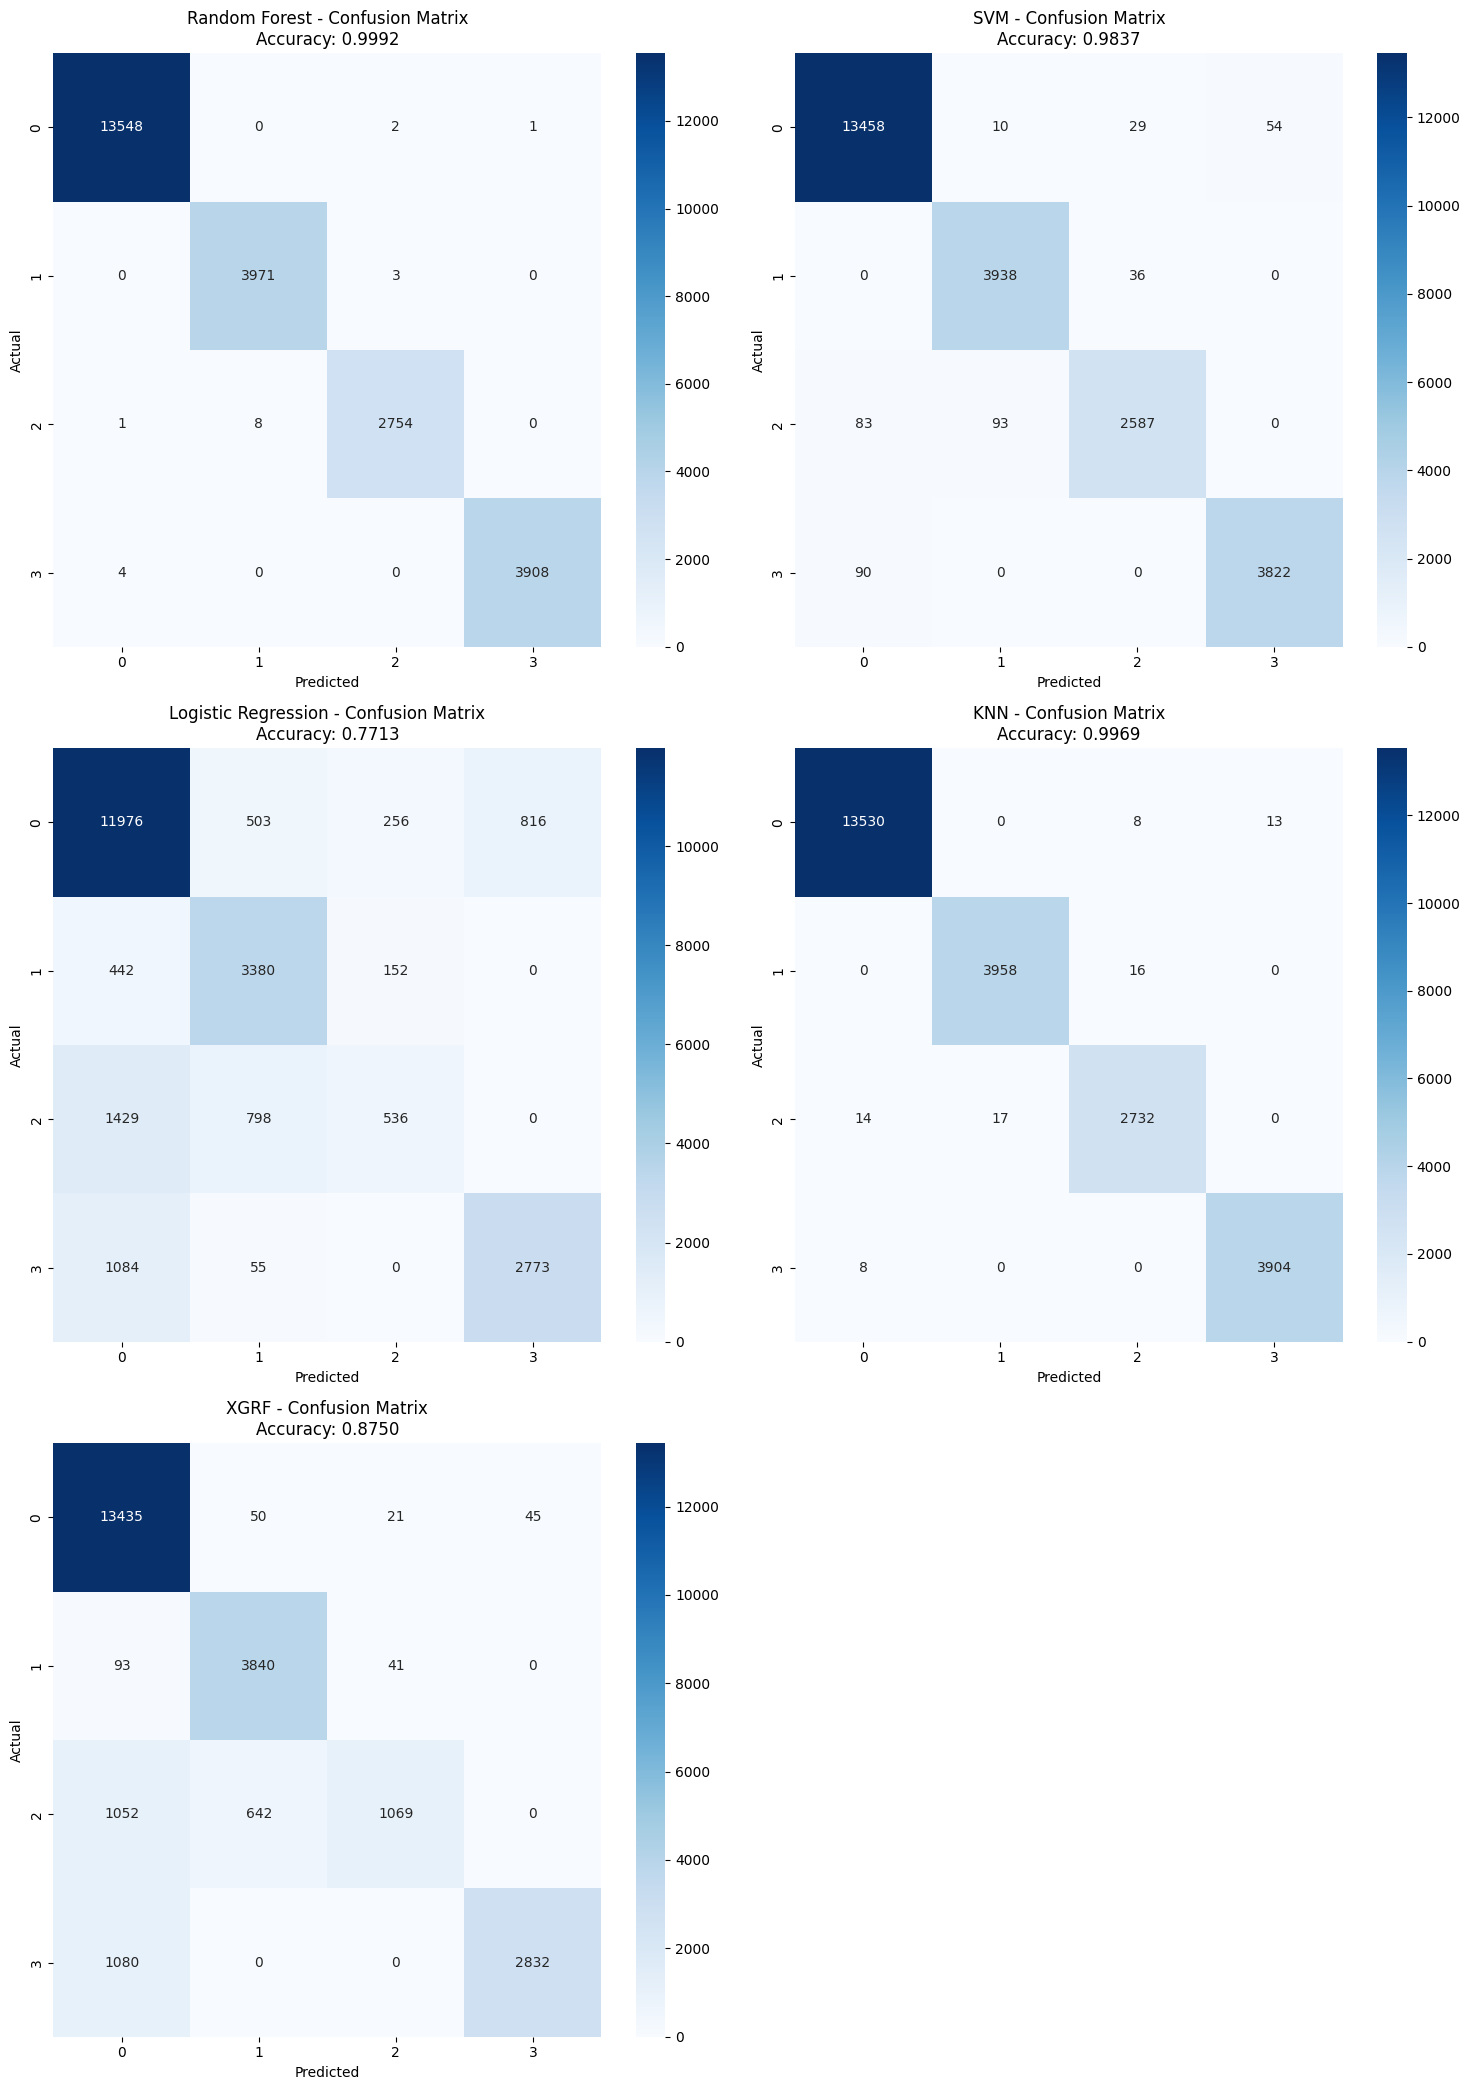

Model Comparison:


,Model,Accuracy,CV Mean,CV Std
0,Random Forest,0.9992,0.9986,0.0002
1,SVM,0.9837,0.9832,0.0013
2,Logistic Regression,0.7713,0.7741,0.0023
3,KNN,0.9969,0.9950,0.0006
4,XGRF,0.8750,0.8758,0.0073


In [32]:
# Plot classification result
n_models = len(results)
n_cols = 2
n_rows = (n_models + 1) // 2 # Ceilling division to ensure enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes to 1D for easier indexing

for idx, (name, result) in enumerate(results.items()):
    
    # Confusion matrix
    cm = confusion_matrix(y_test, result['prediction'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} - Confusion Matrix\nAccuracy: {result["accuracy"]:.4f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
 

# Remove any unused subplots
for idx in range(n_models, len(axes)):
    fig.delaxes(axes[idx])
        
plt.tight_layout()
plt.show()

# Model comparison
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'CV Mean': [results[model]['cv_mean'] for model in results.keys()],
    'CV Std': [results[model]['cv_std'] for model in results.keys()]
})

print("Model Comparison:")
display(model_comparison.round(4))    

In [35]:
print(model_comparison.sort_values('Accuracy', ascending=False).to_string(index=False))

              Model  Accuracy  CV Mean   CV Std
      Random Forest  0.999215 0.998574 0.000155
                KNN  0.996860 0.995031 0.000641
                SVM  0.983678 0.983171 0.001312
               XGRF  0.875041 0.875784 0.007271
Logistic Regression  0.771281 0.774120 0.002257


We choose random forest as the best model for classification

In [38]:
rf_models = classifiers['Random Forest']

rf_models.fit(X_train_scaled, y_train)
rf_pred = rf_models.predict(X_test_scaled)
accuracy = accuracy_score(y_test, rf_pred)

print('Accuracy:', accuracy)

print('Classification Report:')
print(classification_report(y_test, rf_pred))

Accuracy: 0.9992148760330578
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13551
           1       1.00      1.00      1.00      3974
           2       1.00      1.00      1.00      2763
           3       1.00      1.00      1.00      3912

    accuracy                           1.00     24200
   macro avg       1.00      1.00      1.00     24200
weighted avg       1.00      1.00      1.00     24200



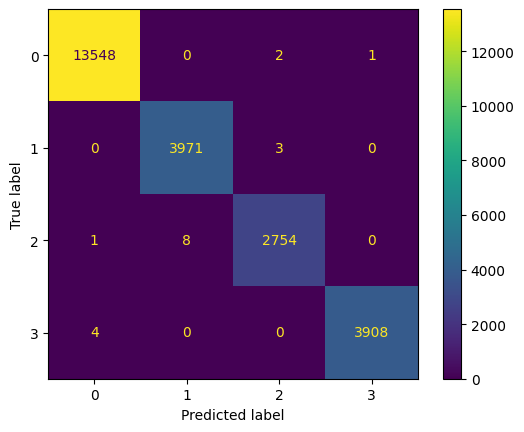

In [46]:
rf_cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_models.classes_)
disp.plot()

In [47]:
joblib.dump(rf_models, '../models/rf_models.joblib')

['../models/rf_models.joblib']

## 6. Clustering Analysis

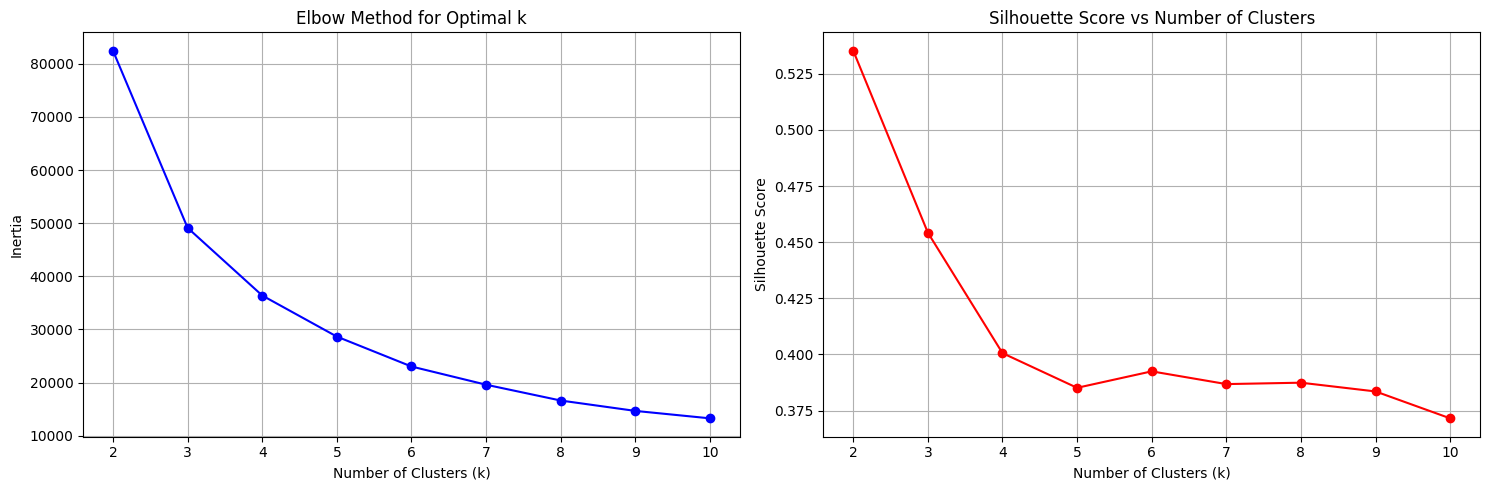

Silhouette Scores:
k=2: 0.5353
k=3: 0.4543
k=4: 0.4006
k=5: 0.3852
k=6: 0.3925
k=7: 0.3868
k=8: 0.3874
k=9: 0.3835
k=10: 0.3716


In [63]:
# Prepare data for clustering (without target variable)
x_clustering = df_processed[['Umur (bulan)', 'Tinggi Badan (cm)']]
x_clustering_scaled = StandardScaler().fit_transform(x_clustering)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_clustering_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_clustering_scaled, kmeans.labels_))
    
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print('Silhouette Scores:')
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

## 7. Apply Different Clustering Algorithms

In [64]:
# Apply different clustering algorithms
clustering_algorithms = {
    'KMeans (k=4)': KMeans(n_clusters=4, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=4),
    # 'Agglomerative': AgglomerativeClustering(n_clusters=4)
}

clustering_results = {}

for name, algorithm in clustering_algorithms.items():
    # fit the algorithm
    cluster_labels = algorithm.fit_predict(x_clustering_scaled)
    
    # Calculate metrics
    if len(set(cluster_labels)) > 1: # check if more than one cluster
        silhouette = silhouette_score(x_clustering_scaled, cluster_labels)
        ari = adjusted_rand_score(y, cluster_labels)
    else: 
        silhouette = -1 
        ari = -1 
    
    clustering_results[name] = {
        'labels': cluster_labels,
        'silhouette': silhouette,
        'ari': ari,
        'n_clusters': len(set(cluster_labels))
    }
    
    print(f"\n{name}:")
    print(f"Number of clusters: {len(set(cluster_labels))}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Adjusted Rand Index: {ari:.4f}")


KMeans (k=4):
Number of clusters: 4
Silhouette Score: 0.4006
Adjusted Rand Index: 0.0320

DBSCAN:
Number of clusters: 1
Silhouette Score: -1.0000
Adjusted Rand Index: -1.0000


## 8. Clustering Visualization

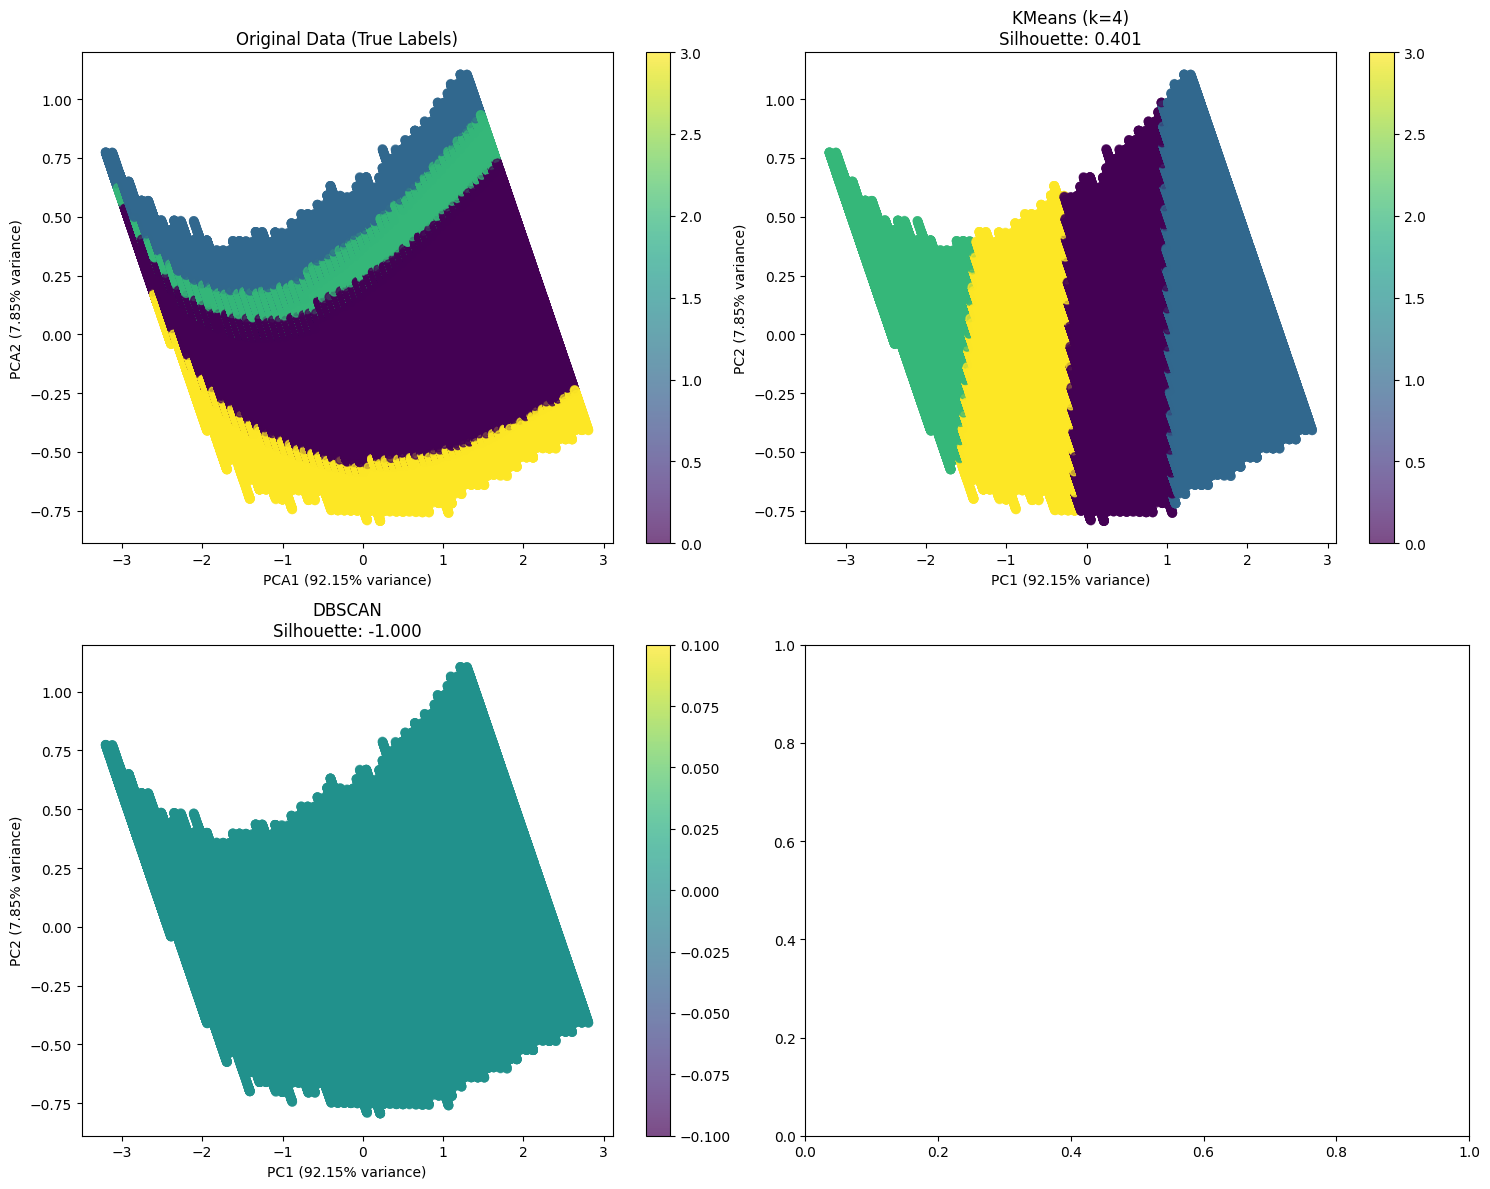

In [65]:
# PCA for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_clustering_scaled)

# plot clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original data with true labels
scatter = axes[0, 0].scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Original Data (True Labels)')
axes[0, 0].set_xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0,0])

# Plot clustering results
plot_idx = 1
for name, result in clustering_results.items():
    if plot_idx < 4:
        row = plot_idx // 2
        col = plot_idx % 2
        
        scatter = axes[row, col].scatter(x_pca[:,0], x_pca[:,1],
                                         c=result['labels'], cmap='viridis', alpha=0.7)
        axes[row, col].set_title(f'{name}\nSilhouette: {result["silhouette"]:.3f}')
        axes[row, col].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[row, col].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, ax=axes[row, col])
        
        plot_idx += 1
        

plt.tight_layout()
plt.show()

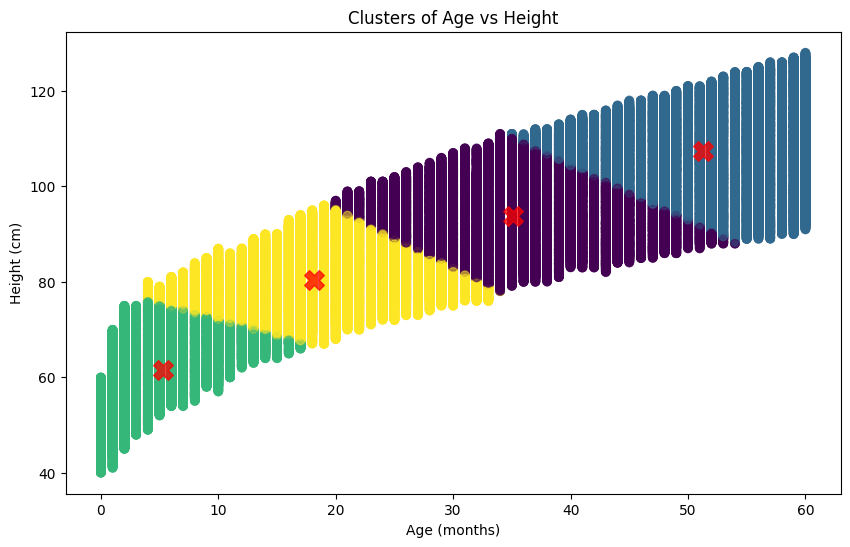

In [70]:
# Fit K-means using the optimal number of clusters 
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(x_clustering_scaled)

# Predicting the cluster labels
labels = kmeans.predict(x_clustering_scaled)

# Create a scaler for clustering data only
clustering_scaler = StandardScaler()
clustering_scaler.fit(x_clustering)

# Visualization of clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_processed['Umur (bulan)'], df_processed['Tinggi Badan (cm)'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Age (months)')
plt.ylabel('Height (cm)')
plt.title('Clusters of Age vs Height')

# Transform cluster centers back to original scale
centers = clustering_scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Marking the cluster centers
plt.show()

## 9. Feature Importance Analysis

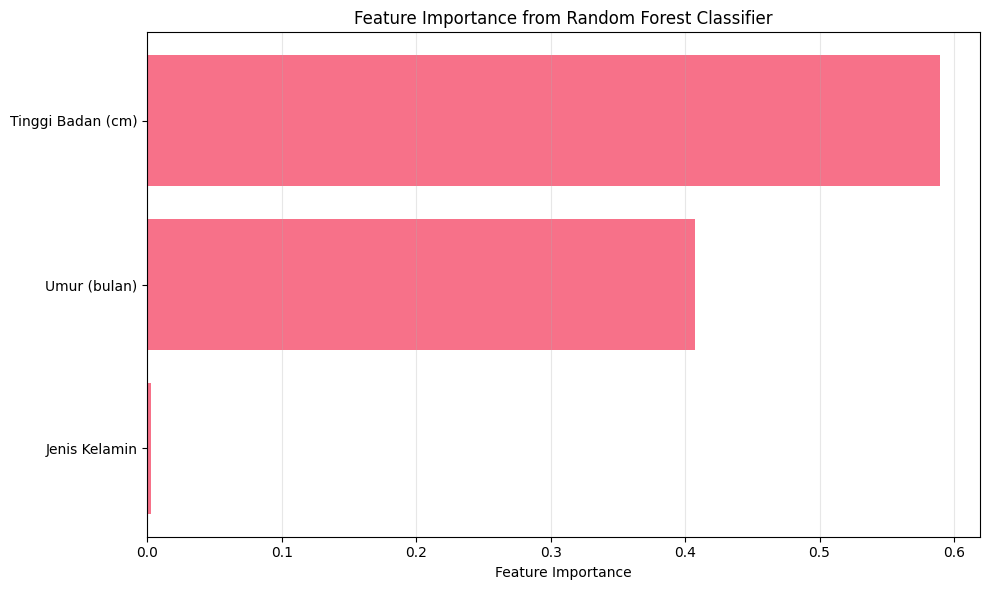

Feature Importance:
Umur (bulan): 0.4077
Jenis Kelamin: 0.0025
Tinggi Badan (cm): 0.5899


In [71]:
# Feature importance from random forest
best_classifier = classifiers['Random Forest']
feature_names = ['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']
feature_importance = best_classifier.feature_importances_

# Create feature importance plot
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.grid(axis='x', alpha=.3)
plt.tight_layout()
plt.show()

print("Feature Importance:")
for feature, importance in zip(feature_names, feature_importance):
    print(f'{feature}: {importance:.4f}')

## 10. Summary dan Kesimpulan

In [72]:
# Create summary report
print("="*60)
print('SUMMARY REPORT - Stunting Classification & Clustering')
print("="*60)

print('\n1. Dataset Overview:')
print(f'    - Total samples: {len(df)}')
print(f'    - Features: {list(df.columns[:-1])}')
print(f'    - Target classes: {list(df["Status Gizi"].unique())}')

print('\n2. Classification Results:')
best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
print(f'    - Best performing model: {best_model}')
print(f'    - Best accuracy: {results[best_model]["accuracy"]:.4f}')
print(f'    - Cross validation score: {results[best_model]["cv_mean"]:.4f}')

print('\n3. Clustering Results:')
best_clustering = max(clustering_results.keys(), key=lambda x: clustering_results[x]['silhouette'])
print(f'    - Best clustering method: {best_clustering}')
print(f'    - Best silhouette score: {clustering_results[best_clustering]['silhouette']:.4f}')
print(f'    - Number of clusters: {clustering_results[best_clustering]["n_clusters"]}')


print('\n4. Key Insights:')
print(f'    - Most important feature: {feature_names[np.argmax(feature_importance)]}')
print(f'    - Feature importance: {max(feature_importance):.4f}')

SUMMARY REPORT - Stunting Classification & Clustering

1. Dataset Overview:
    - Total samples: 120999
    - Features: ['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']
    - Target classes: ['stunted', 'tinggi', 'normal', 'severely stunted']

2. Classification Results:
    - Best performing model: Random Forest
    - Best accuracy: 0.9992
    - Cross validation score: 0.9986

3. Clustering Results:
    - Best clustering method: KMeans (k=4)
    - Best silhouette score: 0.4006
    - Number of clusters: 4

4. Key Insights:
    - Most important feature: Tinggi Badan (cm)
    - Feature importance: 0.5899
